# Auto Encoders

In [1]:
def get_free_gpu():
    from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetMemoryInfo, nvmlDeviceGetCount
    nvmlInit()

    return np.argmax([
        nvmlDeviceGetMemoryInfo(nvmlDeviceGetHandleByIndex(i)).free
        for i in range(nvmlDeviceGetCount())
    ])

In [2]:
import numpy as np
import torch
import torchvision

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


if torch.cuda.is_available():
    cuda_id = get_free_gpu()
    DEVICE = 'cuda:%d' % (get_free_gpu(), )
    print('Selected %s' % (DEVICE, ))
else:
    DEVICE = 'cpu'
    print('WARNING: using cpu!')

### please, don't remove the following line
x = torch.tensor([1], dtype=torch.float32).to(DEVICE)

Selected cuda:2


## Loading data

In [3]:
from torchvision.datasets import MNIST

ds_train = MNIST("../../data/", train=True, download=True)
ds_test = MNIST("../../data/", train=False, download=True)

data_train = ds_train.data.reshape(-1, 1, 28, 28).cpu().numpy().astype(np.float32) / 255

dataset_test = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        (ds_test.data.reshape(-1, 1, 28, 28).to(torch.float32) / 255).to(DEVICE)
    ),
    batch_size=32
)

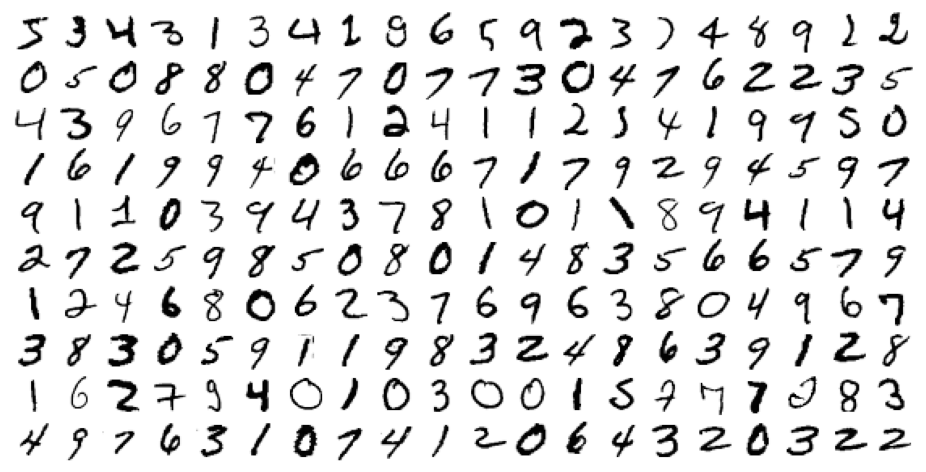

In [4]:
plt.figure(figsize=(12, 6), dpi=100)
plt.axis('off')
_ = plt.imshow(
    np.concatenate(
        np.concatenate(data_train[:200].reshape(20, 10, 28, 28), axis=2),
        axis=0
    ),
    cmap=plt.cm.Greys
)

## Building AE

In [5]:
class View(torch.nn.Module):
    def __init__(self, *shape):
        super(View, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

In [6]:
n = 8

code_size = 4 * n

encoder = torch.nn.Sequential(
    ### 26 x 26
    torch.nn.Conv2d(1, 2 * n, kernel_size=3, stride=1), torch.nn.LeakyReLU(),
    ### 12 x 12
    torch.nn.Conv2d(2 * n, 2 * n, kernel_size=3, stride=2), torch.nn.LeakyReLU(),
    
    ### 10 x 10
    torch.nn.Conv2d(2 * n, 3 * n, kernel_size=3, stride=1), torch.nn.LeakyReLU(),
    ### 4 x 4
    torch.nn.Conv2d(3 * n, 3 * n, kernel_size=3, stride=2), torch.nn.LeakyReLU(),
    
     ### 2 x 2
     torch.nn.Conv2d(3 * n, 4 * n, kernel_size=3, stride=1), torch.nn.LeakyReLU(),

     torch.nn.Flatten(),
     torch.nn.Linear(2 * 2 * 4 * n, code_size),
).to(DEVICE)

decoder = torch.nn.Sequential(
    torch.nn.Linear(code_size, 2 * 2 * 4 * n),
    View(-1, 4 * n, 2, 2),
    
    ### 4 x 4
    torch.nn.ConvTranspose2d(4 * n, 3 * n, kernel_size=3, stride=1), torch.nn.LeakyReLU(),
    
    ### 10 x 10
    torch.nn.ConvTranspose2d(3 * n, 3 * n, kernel_size=3, stride=2, output_padding=1), torch.nn.LeakyReLU(),
    ### 12 x 12
    torch.nn.ConvTranspose2d(3 * n, 2 * n, kernel_size=3, stride=1), torch.nn.LeakyReLU(),
    
    ### 24 x 24
    torch.nn.ConvTranspose2d(2 * n, 2 * n, kernel_size=3, stride=2, output_padding=1), torch.nn.LeakyReLU(),
    torch.nn.ConvTranspose2d(2 * n, 1, kernel_size=3, stride=1), torch.nn.LeakyReLU(),
).to(DEVICE)

In [7]:
### checks if shapes are correct
X_batch = torch.tensor(data_train[:10].reshape(-1, 1, 28, 28), device=DEVICE)
decoder(encoder(X_batch)).shape

torch.Size([10, 1, 28, 28])

In [8]:
opt = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()))

## Task 1

Please, complete autoencoder training procedure:
- implement encoding;
- implement decoding;
- compute MSE loss.

Use `loss` variable to hold value of the MSE loss on the current batch.

In [0]:
batch_size = 32
n_epoches = 4
n_batches = len(data_train) // batch_size

losses = np.zeros((n_epoches, n_batches), dtype=np.float32)

for i in tqdm(range(n_epoches)):
    for j in range(n_batches):
        ### Here, we operate with numpy tensors and then cast them to torch.tensor, but,
        ### in general, if possible, keep your dataset in torch tensors
        ### to avoid unnecessary CPU-to-GPU transfers,
        ### e.g., use DataLoader with TensorDataset.
        indx = np.random.randint(0, data_train.shape[0], size=batch_size)
        imgs = data_train[indx]

        X_batch = torch.tensor(imgs,
                               device=DEVICE,
                               dtype=torch.float32,
                               requires_grad=False)

#         code_batch = 
#         X_reconstructed = 
#         loss = MSE

        loss.backward()
        opt.step()
        opt.zero_grad()

        losses[i, j] = loss.item()

In [0]:
plt.plot(np.mean(losses, axis=1), label='MSE')
plt.xlabel('iteration')

In [0]:
with torch.no_grad():
    errors = np.concatenate([
        torch.mean((X - decoder(encoder(X))) ** 2, axis=(1, 2, 3)).cpu().numpy()
        for X, in dataset_test
    ], axis=0)
    
assert np.mean(errors) < 1e-2

### Visual check of reconstruction quality

In [0]:
X = torch.tensor(data_train[:20], device=DEVICE, dtype=torch.float32, requires_grad=False)
X_rec = decoder(encoder(X)).cpu().detach().numpy()

plt.figure(figsize=(40, 2))
plt.axis('off')
plt.imshow(
    np.concatenate(
        np.concatenate([data_train[:20], X_rec], axis=2),
        axis=2
    )[0, :, :],
    cmap=plt.cm.Greys
)

### Algebra in latent space

Unlike Eucledian space, latent space of AE supports linear algebra, i.e.:

$$\mathrm{decode}\big[\alpha \cdot \mathrm{encode}(X_1) + (1 - \alpha) \cdot \mathrm{encode}(X_2)\big]$$

is not a blurry overlay of two images but a realistic image of a digit (mostly)!

In [0]:
n_cols = 20
n_rows = 10
X = torch.tensor(data_train[:2 * n_rows], device=DEVICE, dtype=torch.float32, requires_grad=False)

with torch.no_grad():
    code = encoder(X)
    code1, code2 = code[:n_rows], code[n_rows:]
    alphas = np.linspace(0, 1, num=n_cols)

    results = np.stack([
        decoder(alpha * code1 + (1 - alpha) * code2).cpu().numpy()
        for alpha in alphas
    ], axis=0)

plt.figure(figsize=(2 * n_cols, 2 * n_rows))
plt.axis('off')
plt.imshow(
    np.concatenate(
        np.concatenate(results, axis=-1),
        axis=-2
    )[0, :, :],
    cmap=plt.cm.Greys
)

## Augmenting data via rotations 

In [0]:
def rotate(imgs, angles):
    from PIL import Image

    return np.stack([
        np.array(
            Image.fromarray(img[0, :, :]).rotate(angle, Image.BILINEAR)
        )
        for img, angle in zip(imgs, angles)
    ], axis=0).reshape(-1, 1, 28, 28)

In [0]:
X_rot = rotate(data_train[:200], np.random.uniform(0, 360, size=200))

plt.figure(figsize=(12, 6), dpi=100)
plt.axis('off')
_ = plt.imshow(
    np.concatenate(
        np.concatenate(X_rot.reshape(20, 10, 28, 28), axis=2),
        axis=0
    ),
    cmap=plt.cm.Greys
)

## Task 2

Please train AE like in the previous task, but make it robust to image rotations.

In [0]:
opt = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()))

In [0]:
batch_size = 32
n_epoches = 4
n_batches = len(data_train) // batch_size

losses = np.zeros((n_epoches, n_batches), dtype=np.float32)

for i in tqdm(range(n_epoches)):
    for j in range(n_batches):
        indx = np.random.randint(0, data_train.shape[0], size=batch_size)
        imgs = data_train[indx]

        # YOUR CODE HERE
        raise NotImplementedError()
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        losses[i, j] = loss.item()

In [0]:
rng = np.random.RandomState(seed=1111)

with torch.no_grad():
    errors = list()
    
    for X, in dataset_test:
        X_rot = torch.tensor(
            rotate(X.cpu().numpy(), np.random.uniform(0, 360, size=X.shape[0])),
            device=DEVICE, dtype=torch.float32, requires_grad=False
        )
    
        errors.append(
            torch.mean((X - decoder(encoder(X))) ** 2, axis=(1, 2, 3)).cpu().numpy()
        )

errors = np.concatenate(errors, axis=0)
    
assert np.mean(errors) < 1e-2, 'Reconstruction error is too large %.3lf' % (np.mean(errors), )

In [0]:
X_rot = rotate(data_train[:20], np.random.uniform(0, 360, size=200))

x = torch.tensor(
    X_rot,
    device=DEVICE, dtype=torch.float32, requires_grad=False
)
x_rec = decoder(encoder(x)).cpu().detach().numpy()

plt.figure(figsize=(40, 2))
plt.axis('off')
plt.imshow(
    np.concatenate(
        np.concatenate([X_rot, x_rec], axis=2),
        axis=2
    )[0, :, :],
    cmap=plt.cm.Greys
)

## Linear algebra

I doesn't look like rotation is a linear operation even in the latent space... Why?

In [0]:
n_cols = 20
n_rows = 10

X1 = torch.tensor(data_train[:n_rows], device=DEVICE, dtype=torch.float32, requires_grad=False)
X2 = torch.tensor(
    rotate(data_train[:n_rows], np.repeat(90, n_cols)),
    device=DEVICE, dtype=torch.float32, requires_grad=False
)

with torch.no_grad():
    code1 = encoder(X1)
    code2 = encoder(X2)
    
    alphas = np.linspace(0, 1, num=n_cols)

    results = np.stack([
        decoder(alpha * code1 + (1 - alpha) * code2).cpu().numpy()
        for alpha in alphas
    ], axis=0)

plt.figure(figsize=(2 * n_cols, 2 * n_rows))
plt.axis('off')
plt.imshow(
    np.concatenate(
        np.concatenate(results, axis=-1),
        axis=-2
    )[0, :, :],
    cmap=plt.cm.Greys
)

## Approximating rotation (optional)

Here, we aim to approximate image rotation, training AE to rotate an image by a given angle.

In [0]:
### Encoder stays, essentially, the same
class Encoder(torch.nn.Module):
    def __init__(self, n, code_size):
        
        super(Encoder, self).__init__()
        
        self.modules = [
            ### 26 x 26
            torch.nn.Conv2d(1, 2 * n, kernel_size=3, stride=1), torch.nn.LeakyReLU(),
            ### 12 x 12
            torch.nn.Conv2d(2 * n, 2 * n, kernel_size=3, stride=2), torch.nn.LeakyReLU(),

            ### 10 x 10
            torch.nn.Conv2d(2 * n, 3 * n, kernel_size=3, stride=1), torch.nn.LeakyReLU(),
            ### 4 x 4
            torch.nn.Conv2d(3 * n, 3 * n, kernel_size=3, stride=2), torch.nn.LeakyReLU(),

             ### 2 x 2
             torch.nn.Conv2d(3 * n, 4 * n, kernel_size=3, stride=1), torch.nn.LeakyReLU(),

             torch.nn.Flatten(),
        ]
        
        for i, f in enumerate(self.modules):
            self.add_module('f%d' % (i, ), f)

        self.code = torch.nn.Linear(2 * 2 * 4 * n, code_size)

    def forward(self, x):
        for f in self.modules:
            x = f(x)
        
        return self.code(x)

In [0]:
### Decoder, however, now receives an additional input - angle of rotation
class Decoder(torch.nn.Module):
    def __init__(self, n, code_size):
        
        super(Decoder, self).__init__()
        
        self.modules = [
            torch.nn.Linear(code_size + 1, 2 * 2 * 4 * n),
            View(-1, 4 * n, 2, 2),

            ### 4 x 4
            torch.nn.ConvTranspose2d(4 * n, 3 * n, kernel_size=3, stride=1), torch.nn.LeakyReLU(),

            ### 10 x 10
            torch.nn.ConvTranspose2d(3 * n, 3 * n, kernel_size=3, stride=2, output_padding=1), torch.nn.LeakyReLU(),
            ### 12 x 12
            torch.nn.ConvTranspose2d(3 * n, 2 * n, kernel_size=3, stride=1), torch.nn.LeakyReLU(),

            ### 24 x 24
            torch.nn.ConvTranspose2d(2 * n, 2 * n, kernel_size=3, stride=2, output_padding=1), torch.nn.LeakyReLU(),
            torch.nn.ConvTranspose2d(2 * n, 1, kernel_size=3, stride=1), torch.nn.LeakyReLU()
        ]
        
        for i, f in enumerate(self.modules):
            self.add_module('f%d' % (i, ), f)
    
    def forward(self, code, angle):
        code = torch.cat([code, angle], axis=1)
        
        x = code
        for f in self.modules:
            x = f(x)
        
        return x

In [0]:
### this AE needs more capacity...
n = 16
code_size = 64

encoder_rot = Encoder(n,  code_size).to(DEVICE)
decoder_rot = Decoder(n,  code_size).to(DEVICE)

In [0]:
x = torch.tensor(data_train[:10].reshape(-1, 1, 28, 28), device=DEVICE)
angles = torch.tensor(np.random.uniform(0, 1, size=(10, 1)).astype('float32'), device=DEVICE)

code = encoder_rot(x)
decoder_rot(code, angles).shape

## Task 3 (optional, not graded)

Find a way to approximate image rotation by AE, i.e.:

$$\mathrm{decode}(\mathrm{encode}(X), \phi) = \mathrm{rotate}(X, \phi).$$

Please, feed decoder with angles from $[-0.5, 0.5]$ where $-0.5$ corresponds to $-180$ degrees, and $0.5$ corresponds to $180$ degrees.

In [0]:
opt_split = torch.optim.Adam(list(encoder_rot.parameters()) + list(decoder_rot.parameters()))

In [0]:
batch_size = 32
n_epoches = 8
n_batches = len(data_train) // batch_size

losses = np.zeros((n_epoches, n_batches), dtype=np.float32)

for i in tqdm(range(n_epoches)):
    for j in range(n_batches):
        # YOUR CODE HERE
        raise NotImplementedError()

In [0]:
plt.plot(np.mean(losses, axis=1), label='MSE')
plt.xlabel('iteration')

In [0]:
X_src = data_train[:20]
angles = np.random.uniform(-0.5, 0.5, size=20)
X_rot = rotate(X_src, angles * 360)

with torch.no_grad():
    x_src = torch.tensor(X_src, device=DEVICE, dtype=torch.float32, requires_grad=False)
    phi = torch.tensor(angles.reshape(-1, 1), device=DEVICE, dtype=torch.float32, requires_grad=False)
    
    code = encoder_rot(x_src)
    X_rec = decoder_rot(code, phi).cpu().numpy()

plt.figure(figsize=(40, 3))
plt.axis('off')
plt.imshow(
    np.concatenate(
        np.concatenate([X_src, X_rec, X_rot], axis=2),
        axis=2
    )[0, :, :],
    cmap=plt.cm.Greys
)

In [0]:
n_cols = 21
n_rows = 10

X = torch.tensor(data_train[:n_rows], device=DEVICE, dtype=torch.float32, requires_grad=False)
angles = np.linspace(-0.5, 0.5, num=n_cols)

with torch.no_grad():
    code = encoder_rot(X)

    results = np.stack([
        decoder_rot(
            code, torch.ones(n_rows, 1, device=DEVICE) * angle
        ).cpu().numpy()
        for angle in angles
    ], axis=0)


### replace 0 degrees rotation with the original image
results[n_cols // 2] = data_train[:n_rows]
    
    
plt.figure(figsize=(2 * n_cols, 2 * n_rows))
plt.axis('off')
plt.imshow(
    np.concatenate(
        np.concatenate(results, axis=-1),
        axis=-2
    )[0, :, :],
    cmap=plt.cm.Greys
)